In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 读取数据
agg = pd.read_csv("data/agg.csv",header=0,sep="\t")
print("agg.shape:",agg.shape)
agg.head()

agg.shape: (80000, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
0,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438,14233
1,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,0.15815,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438,790
2,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,0.15815,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438,82308
3,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,0.15815,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438,90325
4,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,71893


In [3]:
flg = pd.read_csv("data/flg.csv",header=0,sep="\t")
print("flg.shape:",flg.shape)
flg.head()

flg.shape: (80000, 2)


,USRID,FLAG
0,0,0
1,35,0
2,42,0
3,76,0
4,77,0


In [4]:
# 正负样本比例
flg['FLAG'].value_counts()

0    76824
1     3176
Name: FLAG, dtype: int64

In [5]:
data = pd.merge(agg,flg,on='USRID')

usrid = data.pop('USRID')
y = data.pop('FLAG').values
X = data.values
print(X.shape)
print(y.shape)

(80000, 30)
(80000,)


In [6]:
#简单划分train / test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.25, random_state=0)
print("训练集合的正样本数：",len(np.where(y_train==1)[0]))
print("测试集合的正样本数：",len(np.where(y_test==1)[0]))

训练集合的正样本数： 2406
测试集合的正样本数： 770


In [7]:
# 简单示例
from sklearn.metrics import roc_auc_score

# 1.数据结构
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 2.设置参数
param = {'num_leaves':16,
         'objective':'binary',
         'learning_rate':0.1
        }

# 3.训练数据
num_round = 200
lgb_model = lgb.train(param, train_data, num_round)

# 4.预测数据
ypred = lgb_model.predict(X_test)

# 5.评估模型
roc = roc_auc_score(y_test,ypred)

print("test set roc = ",roc)


test set roc =  0.755315625612


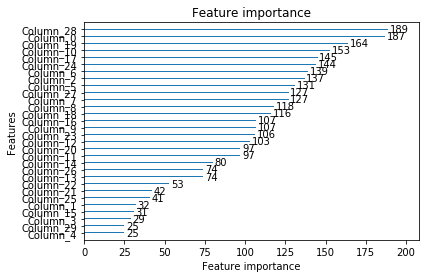

In [8]:
# 特征重要性 ，返回numpy array类型
lgb.plot_importance(lgb_model,
                    title='Feature importance',
                    xlabel='Feature importance', 
                    ylabel='Features',
                    importance_type='split',
                     grid=False)

In [9]:
# 在训练集上观察性能

# 指定评估指标
param['metric'] = 'auc'
# 训练
num_round = 200
lgb_model = lgb.train(param, train_data, num_round,
                      valid_sets=[train_data], 
                      valid_names=['train'], 
                      verbose_eval=20)

[20]	train's auc: 0.755248
[40]	train's auc: 0.778124
[60]	train's auc: 0.804141
[80]	train's auc: 0.825916
[100]	train's auc: 0.84021
[120]	train's auc: 0.854326
[140]	train's auc: 0.866603
[160]	train's auc: 0.879846
[180]	train's auc: 0.890719
[200]	train's auc: 0.898577


In [10]:
# 加入验证集合,可以观察性能（+ 提前停止 ）

# 1.数据结构
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 2.设置参数
param = {'num_leaves':16,
         'objective':'binary',
         'learning_rate':0.1
        }

# 指定评估指标
param['metric'] = 'auc'

# 3.训练数据
num_round = 200
lgb_model = lgb.train(param, train_data, num_round,
                      valid_sets=[train_data,test_data], 
                      valid_names=['train','test'], 
                      early_stopping_rounds=20,
                      verbose_eval=20)
# 提前停止需要在 valid_sets 中至少有一个集合. 如果有多个，它们都会被使用!!!!!!!!!!!!

Training until validation scores don't improve for 20 rounds.
[20]	train's auc: 0.755248	test's auc: 0.743823
[40]	train's auc: 0.778124	test's auc: 0.747455
[60]	train's auc: 0.804141	test's auc: 0.753601
[80]	train's auc: 0.825916	test's auc: 0.758051
[100]	train's auc: 0.84021	test's auc: 0.75991
[120]	train's auc: 0.854326	test's auc: 0.759032
Early stopping, best iteration is:
[105]	train's auc: 0.844206	test's auc: 0.760477


In [11]:
# 如果提前停止,  请注意 train() 将从最后一次迭代中返回一个模型, 而不是最好的一个.

ypred = lgb_model.predict(X_test, num_iteration=-1) # num_iteration  If <0, the best iteration (if exists) is used for prediction.

roc = roc_auc_score(y_test,ypred)

print("test set roc = ",roc)

test set roc =  0.760476629455


In [12]:
# 模型将有 1 个额外的字段: bst.best_iteration.可以获得最好的一个模型

ypred = lgb_model.predict(X_test,  num_iteration=lgb_model.best_iteration)

roc = roc_auc_score(y_test,ypred)

print("test set roc = ",roc)

test set roc =  0.760476629455


In [13]:
# cv
lgb_cv = lgb.cv(param, train_data, num_round,
                      nfold=3,
                      metrics='auc',
                     callbacks=[lgb.callback.print_evaluation(period=20,show_stdv=False),
                                lgb.callback.early_stopping(20)]
                    )
pd.DataFrame(lgb_cv)

Training until validation scores don't improve for 20 rounds.
[20]	cv_agg's auc: 0.73301
[40]	cv_agg's auc: 0.747881
[60]	cv_agg's auc: 0.752162
[80]	cv_agg's auc: 0.754121
[100]	cv_agg's auc: 0.754268
[120]	cv_agg's auc: 0.753266
Early stopping, best iteration is:
[103]	cv_agg's auc: 0.754624 + 0.00267352


,auc-mean,auc-stdv
0,0.687471,0.002327
1,0.708396,0.014810
2,0.708772,0.016369
3,0.714240,0.005515
4,0.715893,0.002625
5,0.717487,0.002863
6,0.718578,0.003741
7,0.719619,0.003910
8,0.721140,0.004422
9,0.720554,0.004096


In [14]:
# Scikit-Learn 的 API

# 设置参数
param_list = {
         'num_leaves':16,
         'objective':'binary',
         'learning_rate':0.1,
         'n_estimators':200,
}
clf = lgb.LGBMClassifier(**param_list)
# 训练
clf.fit(X_train, y_train)

# 预测,正类的概率！！！！！！！！！！！！！
preds = clf.predict_proba(X_test)[:,1]

# 评估
roc = roc_auc_score(y_test,preds)

print("test set roc = ",roc)

test set roc =  0.755315625612


In [15]:
# 设置早停

# 设置参数
param_list = {
         'num_leaves':16,
         'objective':'binary',
         'learning_rate':0.1,
         'n_estimators':200,
}
clf = lgb.LGBMClassifier(**param_list)
# 训练
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_names=['train','test'], 
        eval_metric='auc',
        early_stopping_rounds=20,
        verbose=20)

# 预测,正类的概率！！！！！！！！！！！！！
preds = clf.predict_proba(X_test,num_iteration=clf.best_iteration_)[:,1]

# 评估
roc = roc_auc_score(y_test,preds)

print("test set roc = ",roc)

Training until validation scores don't improve for 20 rounds.
[20]	train's auc: 0.755248	test's auc: 0.743823
[40]	train's auc: 0.778124	test's auc: 0.747455
[60]	train's auc: 0.804141	test's auc: 0.753601
[80]	train's auc: 0.825916	test's auc: 0.758051
[100]	train's auc: 0.84021	test's auc: 0.75991
[120]	train's auc: 0.854326	test's auc: 0.759032
Early stopping, best iteration is:
[105]	train's auc: 0.844206	test's auc: 0.760477
test set roc =  0.760476629455
